In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import xml.etree.ElementTree as ET
import tensorflow as tf
print(tf.__version__)
from glob import glob

import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
if os.getcwd()[-11:] != 'keras-yolo3':
    %cd keras-yolo3
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

datafolder = "/data/NFS/andy/yolo/kaggle_facemask/"

/home/data/andy/anaconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/data/andy/anaconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/data/andy/anaconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/data/andy/anaconda3/envs/tf1/lib/python3

1.12.0


Using TensorFlow backend.


/home/data/andy/kaggle_facemask/keras-yolo3


In [2]:
if not os.path.exists("model_data/yolo.h5"):
    # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
    print("Download YOLOv3 weights from YOLO website...")
    os.system("wget https://pjreddie.com/media/files/yolov3.weights")
    print("Convert the Darknet YOLO model to a Keras model...")
    os.system("python3 convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
    print("Model exist")

Model exist


In [3]:
imgs_path = glob(datafolder + "images/*.png")
imgs_path.sort()
num = int(len(imgs_path)*0.1)

f = open(datafolder + "train.txt", "w")
for i in range(num*9):
    name = imgs_path[i][43:-4]
    f.write(name + "\n")
f.close()

f = open(datafolder + "val.txt", "w")
for i in range(num*9, len(imgs_path)):
    name = imgs_path[i][43:-4]
    f.write(name + "\n")
f.close()

In [4]:
sets=['train', 'val']

# Facemask 的資料類別
classes = ["with_mask", "without_mask", "mask_weared_incorrect"]

# 把 annotation 轉換訓練時需要的資料形態
def convert_annotation(image_id, list_file):
    in_file = open(datafolder + 'annotations/%s.xml'%(image_id))
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

for image_set in sets:
    image_ids = open(datafolder + '%s.txt'%(image_set)).read().strip().split()
    annotation_path = '%s.txt'%(image_set)
    list_file = open(annotation_path, 'w')
    print("save annotation at %s" % annotation_path)
    for image_id in image_ids:
        list_file.write(datafolder + 'images/%s.png'%(image_id))
        convert_annotation(image_id, list_file)
        list_file.write('\n')
    list_file.close()

save annotation at train.txt
save annotation at val.txt


In [5]:
if not os.path.exists("model_data/yolo_weights.h5"):
    print("Converting pretrained YOLOv3 weights for training")
    os.system("python3 convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Pretrained weights exists


In [6]:
warnings.filterwarnings("ignore")

annotation_path = 'train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/mask_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    print("use tiny yolo")
    model = create_tiny_model(input_shape, anchors, num_classes, freeze_body=2, 
                              weights_path='model_data/tiny_yolo_weights.h5')
else:
    print("use yolo")
    model = create_model(input_shape, anchors, num_classes, freeze_body=2, 
                         weights_path='model_data/yolo_weights.h5')

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    # use custom yolo_loss Lambda layer.
    model.compile(optimizer=Adam(lr=1e-3), loss={'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 32
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    history1 = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    # recompile to apply the change
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred})
    print('Unfreeze all of the layers.')

    batch_size = 4 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    history2 = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

use yolo
Create YOLOv3 model with 9 anchors and 3 classes.
Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 689 samples, val on 76 samples, with batch size 32.
Epoch 1/50
21/21 [==============================] - 65s 3s/step - loss: 5751.3512 - val_loss: 1579.0419
Epoch 2/50
21/21 [==============================] - 54s 3s/step - loss: 835.8329 - val_loss: 446.7018
Epoch 3/50
21/21 [==============================] - 55s 3s/step - loss: 361.6996 - val_loss: 280.2626
Epoch 4/50
21/21 [==============================] - 40s 2s/step - loss: 252.0886 - val_loss: 209.9141
Epoch 5/50
21/21 [==============================] - 56s 3s/step - loss: 200.5649 - val_loss: 177.6026
Epoch 6/50
21/21 [==============================] - 56s 3s/step - loss: 172.0745 - val_loss: 150.7939
Epoch 7/50
21/21 [==============================] - 56s 3s/step - loss: 148.1451 - val_loss: 135.0977
Epoch 8/50
21/21 [==============================] - 55s 3s/step - loss: 13

Epoch 76/100
172/172 [==============================] - 74s 433ms/step - loss: 22.0765 - val_loss: 24.3251
Epoch 77/100
172/172 [==============================] - 75s 434ms/step - loss: 21.8788 - val_loss: 24.5969

Epoch 00077: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 78/100
172/172 [==============================] - 75s 434ms/step - loss: 22.3459 - val_loss: 24.3358
Epoch 79/100
172/172 [==============================] - 74s 431ms/step - loss: 22.6564 - val_loss: 25.5053
Epoch 80/100
172/172 [==============================] - 74s 431ms/step - loss: 22.1077 - val_loss: 23.1706
Epoch 81/100
172/172 [==============================] - 74s 433ms/step - loss: 22.2470 - val_loss: 25.0334
Epoch 82/100
172/172 [==============================] - 74s 428ms/step - loss: 22.2945 - val_loss: 25.0338
Epoch 83/100
172/172 [==============================] - 74s 429ms/step - loss: 21.5317 - val_loss: 24.3523

Epoch 00083: ReduceLROnPlateau reducing learning rate to 1.000

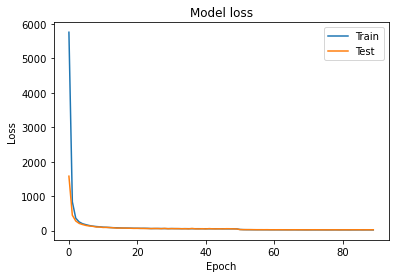

In [10]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'] + history2.history['loss'])
plt.plot(history1.history['val_loss'] + history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig(log_dir + "loss.tiff")
plt.show()